<a href="https://colab.research.google.com/github/orital04/finalProject/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 dir="rtl">
פרויקט גמר - אורי טל
</h1>

<h6 dir="rtl">
ייבוא מערך הנתונים: <br>
אני מייבא את הנתונים מהדרייב שלי, על ידי כך ששמרתי את כל התמונות אשר אשתמש בהן במחברת זו בדרייב שלי.
על כן אבצע כעת mount לדרייב שלי.
</h6>

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import random # על מנת שניתן יהיה להשתמש במספרים רנדומליים (בטווח מסוים שמוגדר בקוד)
import torch # ייבוא ספריית PyTorch
import torch.nn as nn # הרחבה של הספריה שיובאה בשורה הקודמת שלמעשה נותנת את האפשרות ליצור רשתות נוירונים (על כל המשתמע מכך כגון סוגי שכבות בסיסיים וכו')
import torch.optim as optim # בשביל להשתמש באופטימיזציות מסוימות (חלק ניתנות גם בלי זה אך זה מוסיף אפשרויות לשימוש באופטימיזציות שונות)
import torch.utils.data # עבור חלק מבניית הדאטסט
import torchvision # עבור הצגת התמונה שמג'ונרטת בסוף על סמך המשקלים אליהם הגעתי באימון
import torchvision.datasets as dset # עבור חלק מבניית הדטאסט 
import torchvision.transforms as transforms # על מנת לעשות שינוים (טרנספורמציות) על התמונות בדטאסט
import torchvision.utils as vutils # מכיל שימושים הקשורים לויזואליזציה
import numpy as np #  ייבוא ספריית NumPy אשר עוזרת בשימוש במערכים ומטריצות, ומספקת פעולות מתמטיות שניתן לבצע איתם
import matplotlib.pyplot as plt # ייבוא ספריית matplotlib אשר משמשת לויזואליזציה (בפייתון), בעיקר לגרפים וויזואליזציות הקשורות בכך
import matplotlib.animation as animation # matplotlib על מנת ליצור אנימציה "חייה" למעשה על גבי ספריית 
from IPython.display import HTML # בשביל להראות את האנימציה של תהליך האימון של המודל
from torchvision.utils import save_image

In [ ]:
# המיקום (המסלול אליו) בו נמצא הדאטה אשר אשתמש בו בפרויקט
dataroot = "/content/drive/MyDrive/FinalProject/Data"

# מספר המקורות שעובדים על מנת לטעון את הדאטה
workers = 2

# כמות התמונות בכל באץ' באימון
batch_size = 128

# גודל התמונה (מבחינה מרחבית - אורך וגובה) במהלך האימון
image_size = 64

# כמות האפוקים באימון
num_epochs = 50

# קצב הלמידה של האופטימיזציה של המודל
lr = 0.0002

# Beta1 hyperparameter של אופטיימיזצית ADAM
beta1 = 0.5

# כמות מעבדי GPU 
ngpu = 1

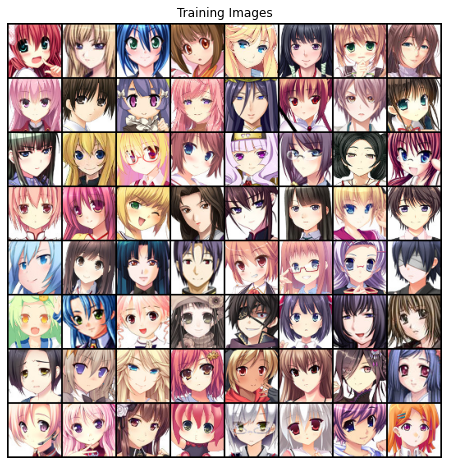

In [ ]:
# יצירת הדאטסט
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size), # משנה את הגודל של התמונה לגודל שהגדרתי מקודם (64)
                               transforms.CenterCrop(image_size), # חותך את התמונה לכיוון האמצע 
                               transforms.ToTensor(), # מעביר את התמונה לטנסור כך שבו זמנית גם מעביר את כל הערכים (הפיקסלים) של התמונה אשר במקור הם בין 0 ל255 - להיות בין 0 ל1
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # מנרמל את הממוצע וסטיית התקן עבור 3 הצ'אנלים (כי התמונות צבעוניות) , כך שערכיהם יהיו בין 1- ל1
                               # להוסיף/לשנות הסבר, בעיקר בשורה האחרונה פה
                           ]))

# הכנה הדאטסט לאימון
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# על מנת לרוץ על GPU
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# מראה חלק מהתמונות שבדטאסט
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# פונקצייה לאתחול המשקלים במודלים - ממוצע 0 וסטיית תקן של 0.02
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# הקוד של המודל המייצר
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False), # שכבת קונבלוציה transposed
            nn.BatchNorm2d(512), # שכבה של נרמול - batch normalization
            nn.ReLU(True), # שכבת אקטיבציה ReLU

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input): # מגדיר איך המודל ירוץ
        return self.main(input)

In [ ]:
# יצירת מייצר והעברה למעבד GPU
netG = Generator(ngpu).to(device)

# אתחול משקלים במייצר
netG.apply(weights_init)

# הדפסת המודל המייצר
print(netG)

# summary
from torchsummary import summary
summary(netG, input_size=(100, 512, 4))

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
# הקוד של המודל המבחין
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False), # שכבת קונבולוציה
            nn.LeakyReLU(0.2, inplace=True), # אקטיבציית leaky ReLU עם שיפוע 0.2
            
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid() # אקטיבציית סיגמוד כך שהפלט יהיה בין 0 ל1
        )
        
    def forward(self, input): # מגדיר איך המודל ירוץ
        return self.main(input)

In [ ]:
# יצירת מבחין תמונות והעברה למעבד GPU
netD = Discriminator(ngpu).to(device)

# אתחול משקלים במבחין
netD.apply(weights_init)

# הדפסת המודל המבחין
print(netD)

# summary
from torchsummary import summary
summary(netD, input_size=(3, 64, 64))

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)
------------------------------

In [ ]:
# (מחיר) פונקציית עלות
criterion = nn.BCELoss()

# יוצר באץ' של וקטורים לטנטיים שבעזרתם אראה ויזואליזציה של ההתקדמות של המייצר
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

# מגדיר כקונבנציות - 1 עבור תמונה אמיתית ו0 עבור תמונה סינתטית
real_label = 1.
fake_label = 0.

# יצירת מייעל למייצר ולמבחין
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# לולאת האימון

# רשימות כדי לשמור ולראות את ההתקדמות בעת תהליך אימון המכונה
img_list = []
G_losses = []
D_losses = []
# אתחול מספר האיטרציות ("הצעדים")
iters = 0

# רץ את כמות אפוקים שהגדרתי קודם לכן (בתחילת המחברת)
for epoch in range(num_epochs):
    # לכל באץ' לפי מה שהוגדר עבור האימון. 0 מסמן שהלולאה מתחילה מההתחלה של הדאטסט
    # מסמן את הדאטה, שבעצם מכיל גם את הדאטה עצמו ולאחר מכן גם אינדקס - dataloader
    # אינדקס שונה - זה פשוט אינדקס של הלולאה הזאת עצמה (לא של הדאטה) - i
    for i, data in enumerate(dataloader, 0):
                
        ############################
        # עדכון רשת המבחין: שואפת למקסם את log(D(x)) + log(1 - D(G(z)))
        ###########################
        #### עדכון מבחין התמונות ####
        ## מאמן על תמונות אמיתיות ##
        netD.zero_grad() # מאתחל ("מנקה") את הנגזרות של המבחין
        # יוצר באץ' של תמונות אמיתיות 
        real_cpu = data[0].to(device) # בונה באץ' של תמונות אמיתיות מתוך הדאטה ומעביר למעבד GPU
        batch_size = real_cpu.size(0) # גודל הבאץ' (גודל הבאץ' במימד הראשון של הדאטה) - צריך לדעת בוודאות (על אף שהוגדר מראש) שכן יכול להיות שבסוף תהליך האימון גודל הבאץ' יהיה שונה ממה שהוגדר
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device) # יוצר טנסור בגודל הבאץ' של התוויות (התוויות הן 1) של התמונות האמיתיות
        output = netD(real_cpu).view(-1) # מעביר (חלחול קדימה) את הבאץ' של התמונות האמיתיות שיצרתי דרך המבחין
        errD_real = criterion(output, label) # מחשב את פונקצית העלות של הבאץ' של התמונות האמיתיות שעברו דרך המבחין לעומת התוויות ש"אמורות" להיות להן (1)
        errD_real.backward() # חישוב נגזרות (גרדיאנטים) של המבחין בחלחול לאחור 
        D_x = output.mean().item() # עושה ממוצע לטנסור ומעביר אותו להיות מספר 

        ## מאמן על תמונות סינתטיות (לא אמיתיות) ##
        noise = torch.randn(batch_size, 100, 1, 1, device=device) # יוצר באץ' של וקטורי רעש לטנטיים
        fake = netG(noise) # יוצר תמונות סינתטיות על ידי העברת וקטורי הרעש שיצרתי קודם - דרך המייצר
        label.fill_(fake_label) # יוצר טנסור של התוויות (התוויות הן 0) של התמונות הסינתטיות
        output = netD(fake.detach()).view(-1) # מעביר (חלחול קדימה) את הבאץ' של התמונות הסינתטיות שיצרתי דרך המבחין 
        errD_fake = criterion(output, label) # מחשב את פונקצית העלות של הבאץ' של התמונות הסינתטיות שעברו דרך המבחין לעומת התוויות ש"אמורות" להיות להן (0)
        errD_fake.backward() # חישוב נגזרות (גרדיאנטים) של המבחין בחלחול לאחור 
        D_G_z1 = output.mean().item() # עושה ממוצע לטנסור ומעביר אותו להיות מספר 
        errD = errD_real + errD_fake # עושה את סכום השגיאות שחושבו בפונקציות העלות עבור תמונות אמיתיות ותמונות סינתטיות
        optimizerD.step() # מבצע את השינוי במבחין בפועל (על סמך הגרדיאנטים שחושבו קודם לכן) - עדכון משקלים (בעזרת המייעל)

        ############################
        # עדכון רשת המייצר: שואפת למקסם את log(D(G(z)))
        ###########################
        netG.zero_grad() # מאתחל ("מנקה") את הנגזרות של המייצר
        label.fill_(real_label) # יוצר טנסור של התוויות (1) של התמונות הסינתטיות שיוצרו קודם 
        output = netD(fake).view(-1) # מעביר (חלחול קדימה) את הבאץ' של התמונות הסינתטיות שיצרתי דרך המבחין 
        errG = criterion(output, label) # מחשב את פונקצית העלות של הבאץ' של התמונות הסינתטיות שעברו דרך המבחין לעומת התוויות ש"אמורות" להיות להן (1)
        errG.backward() # חישוב נגזרות (גרדיאנטים) של המייצר בחלחול לאחור 
        D_G_z2 = output.mean().item() # עושה ממוצע לטנסור ומעביר אותו להיות מספר
        optimizerG.step() # מבצע את השינוי במייצר בפועל (על סמך הגרדיאנטים שחושבו קודם לכן) - עדכון משקלים (בעזרת המייעל)
        
        # מדפיס את תוצאות האימון (כל 50 איטרציות)
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                 % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # שומר את ערכי ההפסדים לאורך האימון
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # בודק את איכות המייצר על ידי שמירת הפלט של המייצר על ידי רעש קבוע (שהגדרתי קודם)
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        iters += 1

[0/50][0/169]	Loss_D: 1.7723	Loss_G: 4.0069	D(x): 0.4012	D(G(z)): 0.4556 / 0.0260
[0/50][50/169]	Loss_D: 0.3427	Loss_G: 10.3104	D(x): 0.8491	D(G(z)): 0.0187 / 0.0004
[0/50][100/169]	Loss_D: 1.0032	Loss_G: 3.4333	D(x): 0.6241	D(G(z)): 0.1148 / 0.0556
[0/50][150/169]	Loss_D: 0.8884	Loss_G: 8.3777	D(x): 0.9048	D(G(z)): 0.4700 / 0.0012
[1/50][0/169]	Loss_D: 0.7287	Loss_G: 6.3181	D(x): 0.9344	D(G(z)): 0.4215 / 0.0035
[1/50][50/169]	Loss_D: 0.6415	Loss_G: 7.1610	D(x): 0.8978	D(G(z)): 0.3176 / 0.0014
[1/50][100/169]	Loss_D: 1.0365	Loss_G: 8.0625	D(x): 0.9211	D(G(z)): 0.4753 / 0.0015
[1/50][150/169]	Loss_D: 0.4935	Loss_G: 5.7621	D(x): 0.8249	D(G(z)): 0.1985 / 0.0054
[2/50][0/169]	Loss_D: 0.6378	Loss_G: 3.8930	D(x): 0.7525	D(G(z)): 0.1523 / 0.0272
[2/50][50/169]	Loss_D: 0.5060	Loss_G: 6.5410	D(x): 0.8636	D(G(z)): 0.2186 / 0.0031
[2/50][100/169]	Loss_D: 0.5989	Loss_G: 4.7278	D(x): 0.7139	D(G(z)): 0.0897 / 0.0168
[2/50][150/169]	Loss_D: 0.2857	Loss_G: 3.6397	D(x): 0.8436	D(G(z)): 0.0730 / 0.0521


In [ ]:
torch.save({
      'D_losses': D_losses,
      'G_losses': G_losses, 
      'optimizerG': optimizerG.state_dict(),
      'optimizerD': optimizerD.state_dict(),
      'netD': netD.state_dict(),
      'netG': netG.state_dict(),
        }, f"DCGAN.pth")

In [ ]:
dict = torch.load('DCGAN.pth') 
netD.load_state_dict(dict.get('netD'))
netG.load_state_dict(dict.get('netG'))
optimizerG.load_state_dict(dict.get('optimizerG'))
optimizerD.load_state_dict(dict.get('optimizerD'))
G_losses = dict.get('G_losses')
D_losses = dict.get('D_losses')
num_train_epochs =dict.get('num_train_epochs')

In [ ]:
for i in range(5):
  noise = torch.randn(64, 100, 1, 1, device=device)
  fake = netG(noise)  
  img_grid_fake = torchvision.utils.make_grid(fake[:5], normalize=True)
  save_image(img_grid_fake, f"gena[{i}].png")

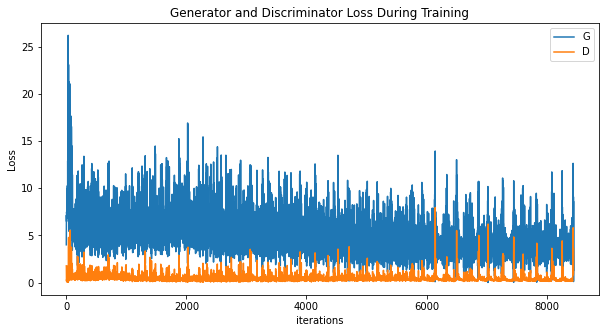

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

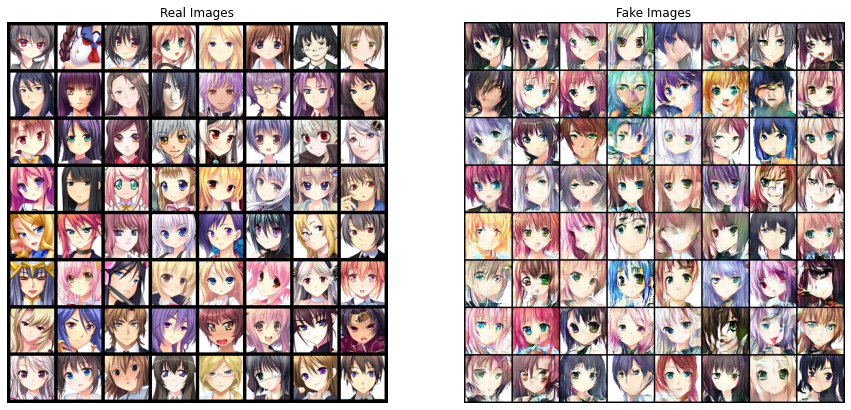

In [ ]:
# לוקח תמונות אמיתיות
real_batch = next(iter(dataloader))

# מציג תמונות אמיתיות
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# מציג תמונות סינתטיות
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()